In [65]:
# HR Employee Attrition Predictor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
import seaborn as sns
import sklearn.metrics as metrics
import plotly.graph_objs as go

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE

In [66]:
def encodeOutputVariable(y):
    labelencoder_Y_Origin = LabelEncoder()
    y = labelencoder_Y_Origin.fit_transform(y.astype(str))
    return y

def encodeCategoricalData(X, index):
    # encode categorical data
    labelencoder_X_Origin = LabelEncoder()
    X[:, index] = labelencoder_X_Origin.fit_transform(X[:, index].astype(str))
    return X    

def encodeHotEncoder(X, numberOfCategories):
    onehotencoder = OneHotEncoder(categorical_features = [numberOfCategories])
    X = onehotencoder.fit_transform(X.astype(str)).toarray()  
    X = X[:, 1:]
    return X

def minimumValues(train):
    return [0 if math.isnan(x) else x for x in train]

def minimumDelay(x):
    return 0 if np.isnan(x) or x < 0 else x

def outputPredictorResults(y_test, y_pred, title):
    # output results for Neural network Classification
    print("\nFor", title, "Classification")
    print("Accuracy Score of Prediction : ", metrics.accuracy_score(y_test, y_pred) * 100)
    print("\nConfusion Matrix")
    print(pd.crosstab(y_test.ravel(), y_pred.ravel(), rownames=['True'], colnames=['Predicted'], margins=True))
    print("\nClassification Report")
    print(metrics.classification_report(y_test, y_pred))
    print("Zero One Loss: ", metrics.zero_one_loss(y_test, y_pred))
    print("Log Loss:      ", metrics.log_loss(y_test, y_pred))
    print("ROC AUC Score: ", metrics.roc_auc_score(y_test, y_pred, average="micro"))
    graphROCCurve(y_test, y_pred, y)
    
def graphROCCurve(y_test, y_pred, y):    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def graphFeaturesImportant(rf_classifier, dataset):
    trace = go.Scatter(
        y = rf_classifier.feature_importances_, 
        x = dataset.columns.values, mode = "markers",
        marker = dict(
            sizemode = "diameter", sizeref=1, size=13, 
            color=rf_classifier.feature_importances_, colorscale="Portland",
            showscale=True
        ),
        text = dataset.columns.values
    )
    data = [trace]

    layout = go.Layout(
        autosize = True,
        title = "Random Forest Feature Importance",
        hovermode = "closest",
        xaxis = dict(
            ticklen=5, showgrid=True, zeroline=True, showline=True
        ),
        yaxis = dict(
            title="Feature Importance", showgrid=True, zeroline=True,
            ticklen=5, gridwidth=2
        ),
        showlegend=False
    )
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    
# developing the Multi Layer Perceptron Neural Network
def creatingNeuralNetworkPredictor(X_train, y_train, X_test, y_test):
    print("\nNeural Network Classifier Section")
    print("---------------------------------")
    
    # initialize the Multi Layer Perceptron Neural Network 
    mlp_classifier = MLPClassifier(solver="adam", alpha=1e-5, max_iter=500,
                               hidden_layer_sizes=(13, 13, 13))
    
    oversampler = SMOTE(random_state=0)
    smote_X_train, smote_y_train = oversampler.fit_sample(X_train, y_train)
    
    # fitting the Multi Layer Perceptron to the training set
    mlp_classifier.fit(X_train, y_train)
    
    # Predicting the Test set results
    mlp_y_pred = mlp_classifier.predict(X_test)
    
    # use the threshold of error to determine whether a prediction is valid
    mlp_y_pred = (mlp_y_pred > 0.5)
    
    # making the confusion matrix
    cm = metrics.confusion_matrix(y_test.ravel(), mlp_y_pred.ravel())
    
    print("Training set Score: ", mlp_classifier.score(X_train, y_train))
    print("Testing set Score: ", mlp_classifier.score(X_test, y_test))    
    
    # output results
    outputPredictorResults(y_test, mlp_y_pred, "Neural Network")
    
# developing the Random Forest Classifier
def creatingRandomForestPredictor(X_train, y_train, X_test, y_test):
    print("\nRandom Forest Classifier Section")
    print("---------------------------------")
    
    # initialize the Multi Layer Perceptron Neural Network 
    random_forest_classifier = RandomForestClassifier(**{'n_jobs': -1,
        'n_estimators': 800,
        'warm_start': True, 
        'max_features': 0.3,
        'max_depth': 9,
        'min_samples_leaf': 2,
        'max_features' : 'sqrt',
        'random_state' : 0,
        'verbose': 0
                                                      })
    
    oversampler = SMOTE(random_state=0)
    smote_X_train, smote_y_train = oversampler.fit_sample(X_train, y_train)
    
    # fitting Random Forest to the training set
    random_forest_classifier.fit(smote_X_train, smote_y_train)
    
    # Predicting the Test set results
    rf_y_pred = random_forest_classifier.predict(X_test)
    
    # use the threshold of error to determine whether a prediction is valid
    rf_y_pred = (rf_y_pred > 0.5)
    
    # making the confusion matrix
    cm = metrics.confusion_matrix(y_test.ravel(), rf_y_pred.ravel())
    
    print("Training set Score: ", random_forest_classifier.score(X_train, y_train))
    print("Testing set Score: ", random_forest_classifier.score(X_test, y_test))    
    
    # output results
    outputPredictorResults(y_test, rf_y_pred, "Random Forest")
    graphFeaturesImportant(random_forest_classifier, dataset)

In [67]:
# importing the data
dataset = pd.read_csv("./data/employee_attrition.csv")
dataset.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [68]:
X = dataset.iloc[:, 0:34].values
X = np.delete(X, [1], axis=1)

In [69]:
y = dataset.iloc[:, 1].values

In [70]:
# encode categorical data
X = encodeCategoricalData(X, 1)
X = encodeCategoricalData(X, 3)
X = encodeCategoricalData(X, 6)
X = encodeCategoricalData(X, 10)
X = encodeCategoricalData(X, 14)
X = encodeCategoricalData(X, 16)
X = encodeCategoricalData(X, 20)
X = encodeCategoricalData(X, 21)

# remove dummy columns
X = encodeHotEncoder(X, 4)
print("Total", len(X[0]), "features")

Total 60 features


In [71]:
y = encodeOutputVariable(y)

In [72]:
# splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [73]:
# feature scaling 
sc = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Summary Info About the Dataset
Does category contain null values?
Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel

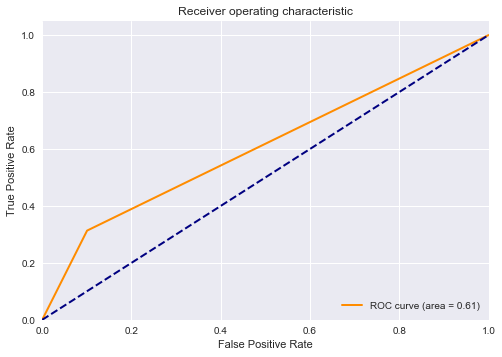


Random Forest Classifier Section
---------------------------------
Training set Score:  0.980563654033
Testing set Score:  0.859410430839

For Random Forest Classification
Accuracy Score of Prediction :  85.9410430839

Confusion Matrix
Predicted  False  True  All
True                       
0            354     4  358
1             58    25   83
All          412    29  441

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.99      0.92       358
          1       0.86      0.30      0.45        83

avg / total       0.86      0.86      0.83       441

Zero One Loss:  0.140589569161
Log Loss:       4.85579894529
ROC AUC Score:  0.64501581746


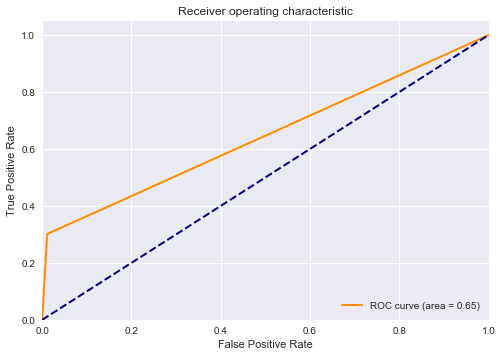

In [74]:
# outputting data summary
print("Summary Info About the Dataset")
print("Does category contain null values?")
print(dataset.isnull().any(), "\n")
print("Said Yes to Attrition: ", y[(y == 1)].size)
print("Said No to Attrition:  ", y[(y == 0)].size)
print("Total responses:       ", y.size)

creatingNeuralNetworkPredictor(X_train, y_train, X_test, y_test)
creatingRandomForestPredictor(X_train, y_train, X_test, y_test)